# Import the required libraries

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.applications.densenet import preprocess_input


# Connect to drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

train_dir = "/content/drive/MyDrive/Bangkit 2024/Split_Augmentation/Dataset/train"
valid_dir = "/content/drive/MyDrive/Bangkit 2024/Split_Augmentation/Dataset/valid"
test_dir = "/content/drive/MyDrive/Bangkit 2024/Split_Augmentation/Dataset/test"


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Data preparation

In [ ]:
# Ensure the directories exist
assert os.path.isdir(train_dir), f"Training directory not found: {train_dir}"
assert os.path.isdir(valid_dir), f"Validation directory not found: {valid_dir}"
assert os.path.isdir(test_dir), f"Test directory not found: {test_dir}"

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    fill_mode='nearest',
    brightness_range=[0.8, 1.2],
    horizontal_flip=True)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_batches = train_datagen.flow_from_directory(train_dir, target_size=(416, 416), batch_size=16, class_mode='categorical')
valid_batches = val_datagen.flow_from_directory(valid_dir, target_size=(416, 416), batch_size=16, class_mode='categorical')
test_batches = test_datagen.flow_from_directory(test_dir, target_size=(416, 416), batch_size=16, class_mode='categorical', shuffle=False)


Found 3866 images belonging to 3 classes.
Found 1257 images belonging to 3 classes.
Found 1281 images belonging to 3 classes.


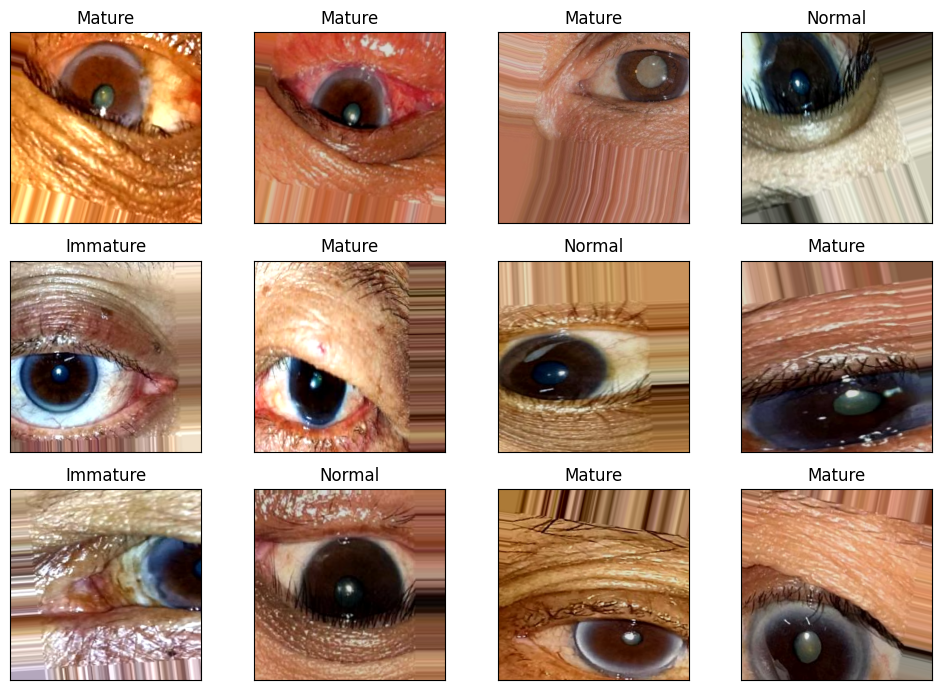

In [ ]:
# Invert the class_indices dictionary
class_indices = {v: k for k, v in train_batches.class_indices.items()}

# Plot some images from the training batches with their labels
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(10, 7), subplot_kw={'xticks': [], 'yticks': []})
for i, ax in enumerate(axes.flat):
    img, label = train_batches.next()
    ax.imshow(img[0])
    class_idx = label[0].argmax()
    ax.set_title(class_indices[class_idx])
plt.tight_layout()
plt.show()


<ipython-input-17-884511caccbc>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x = vc.index, y = vc, palette = "rocket")


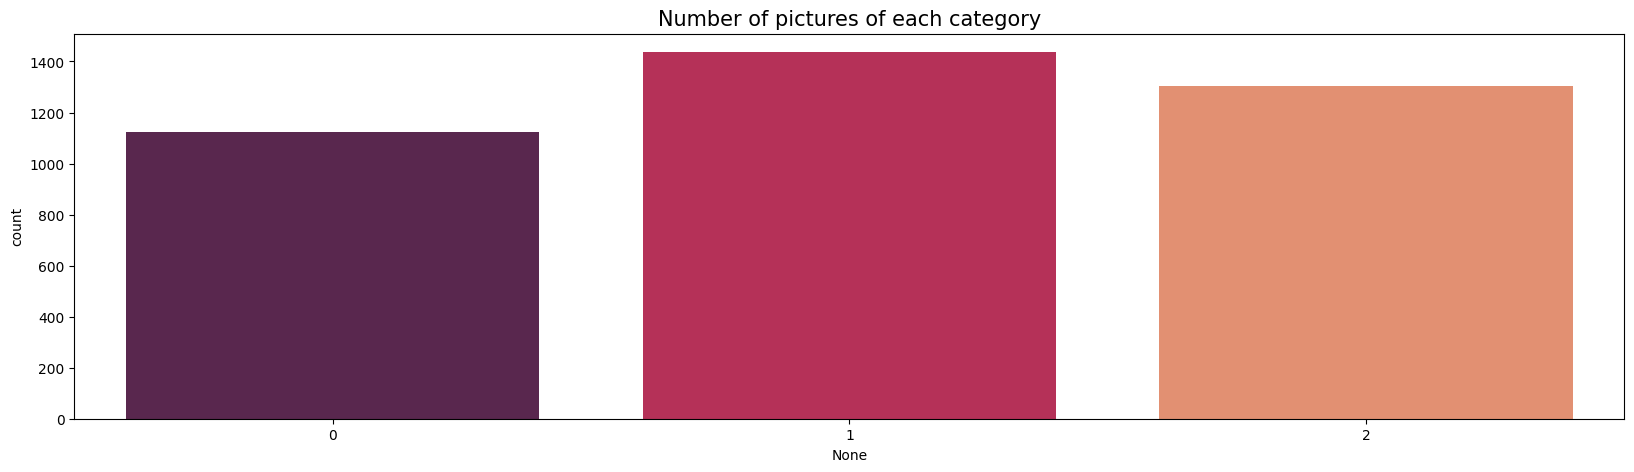

In [ ]:
vc = pd.Series(train_batches.classes).value_counts()
plt.figure(figsize=(20,5))
sns.barplot(x = vc.index, y = vc, palette = "rocket")
plt.title("Number of pictures of each category", fontsize = 15)
plt.show()

# Load Pretrained Model

In [ ]:
# Load DenseNet201 model
input_shape = (416, 416, 3)
base_model = DenseNet201(weights='imagenet', include_top=False, input_shape=input_shape)

for layer in base_model.layers:
    layer.trainable = False

x = layers.GlobalMaxPooling2D()(base_model.output)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dropout(0.15)(x)
x = layers.Dense(3, activation='softmax')(x)

model = models.Model(inputs=base_model.input, outputs=x)
optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.0001)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 416, 416, 3)]        0         []                            
                                                                                                  
 zero_padding2d_2 (ZeroPadd  (None, 422, 422, 3)          0         ['input_2[0][0]']             
 ing2D)                                                                                           
                                                                                                  
 conv1/conv (Conv2D)         (None, 208, 208, 64)         9408      ['zero_padding2d_2[0][0]']    
                                                                                                  
 conv1/bn (BatchNormalizati  (None, 208, 208, 64)         256       ['conv1/conv[0][0]']    

# Build Model and Training

In [ ]:
class MyCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if logs.get('loss') < 0.1 and logs.get('val_loss') < 0.1:
            print("\nStopped, Accuracy  98%")
            self.model.stop_training = True

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint

checkpoint_path = '/content/drive/MyDrive/Bangkit 2024/H5/Desnet.h5'
checkpoint_callback = ModelCheckpoint(filepath=checkpoint_path,
                                      monitor='val_loss',
                                      save_best_only=True,
                                      save_weights_only=False,
                                      mode='min',
                                      verbose=1)

callbacks = MyCallback()

history = model.fit(train_batches,
                    validation_data=valid_batches,
                    steps_per_epoch=len(train_batches),
                    validation_steps=len(valid_batches),
                    epochs=20,
                    callbacks=[callbacks, checkpoint_callback])

Epoch 1/20
242/242 [==============================] - ETA: 0s - loss: 1.2557 - accuracy: 0.5998
Epoch 1: val_loss improved from inf to 0.75838, saving model to /content/drive/MyDrive/Bangkit 2024/H5/Desnet.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


242/242 [==============================] - 1138s 4s/step - loss: 1.2557 - accuracy: 0.5998 - val_loss: 0.7584 - val_accuracy: 0.6874
Epoch 2/20
242/242 [==============================] - ETA: 0s - loss: 0.5501 - accuracy: 0.7775
Epoch 2: val_loss improved from 0.75838 to 0.27629, saving model to /content/drive/MyDrive/Bangkit 2024/H5/Desnet.h5
242/242 [==============================] - 228s 939ms/step - loss: 0.5501 - accuracy: 0.7775 - val_loss: 0.2763 - val_accuracy: 0.8894
Epoch 3/20
242/242 [==============================] - ETA: 0s - loss: 0.3960 - accuracy: 0.8381
Epoch 3: val_loss improved from 0.27629 to 0.17988, saving model to /content/drive/MyDrive/Bangkit 2024/H5/Desnet.h5
242/242 [==============================] - 230s 950ms/step - loss: 0.3960 - accuracy: 0.8381 - val_loss: 0.1799 - val_accuracy: 0.9411
Epoch 4/20
242/242 [==============================] - ETA: 0s - loss: 0.3217 - accuracy: 0.8725
Epoch 4: val_loss improved from 0.17988 to 0.15913, saving model to /conten

# Visualize Model Performance

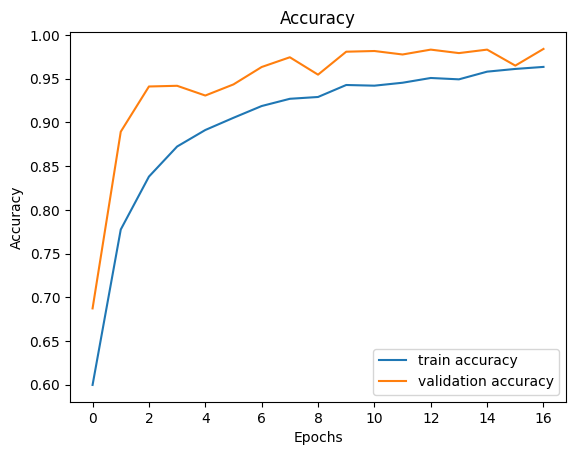

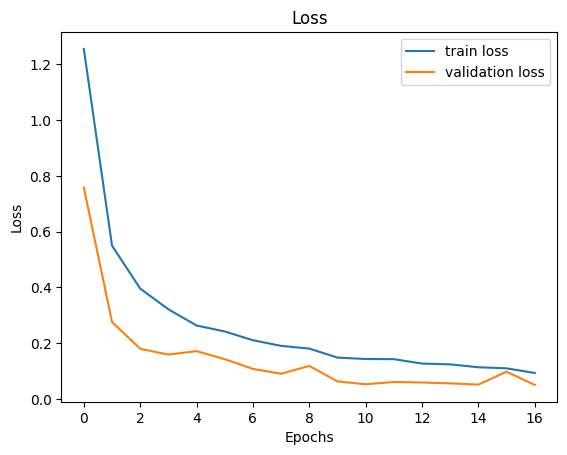

In [ ]:
# Plot accuracy
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='validation accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot loss
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


# Evaluate the Model

In [ ]:
# Evaluate the model
test_loss, test_accuracy = model.evaluate(test_batches, verbose=1)
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")


81/81 [==============================] - 423s 5s/step - loss: 0.0542 - accuracy: 0.9844
Test Accuracy: 0.9844
Test Loss: 0.0542


# Predict on Test Data

In [ ]:
# Predict test data
class_labels = list(test_batches.class_indices.keys())
test_batches.reset()
predictions = model.predict(test_batches, verbose=1)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_batches.classes

81/81 [==============================] - 22s 234ms/step


In [ ]:
# Confusion matrix
conf_matrix = confusion_matrix(true_classes, predicted_classes)
print('Confusion Matrix')
print(conf_matrix)


Confusion Matrix
[[371   2   5]
 [  7 432   6]
 [  0   0 458]]


In [ ]:
# Classification report
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print('Classification Report')
print(report)

Classification Report
              precision    recall  f1-score   support

    Immature       0.98      0.98      0.98       378
      Mature       1.00      0.97      0.98       445
      Normal       0.98      1.00      0.99       458

    accuracy                           0.98      1281
   macro avg       0.98      0.98      0.98      1281
weighted avg       0.98      0.98      0.98      1281



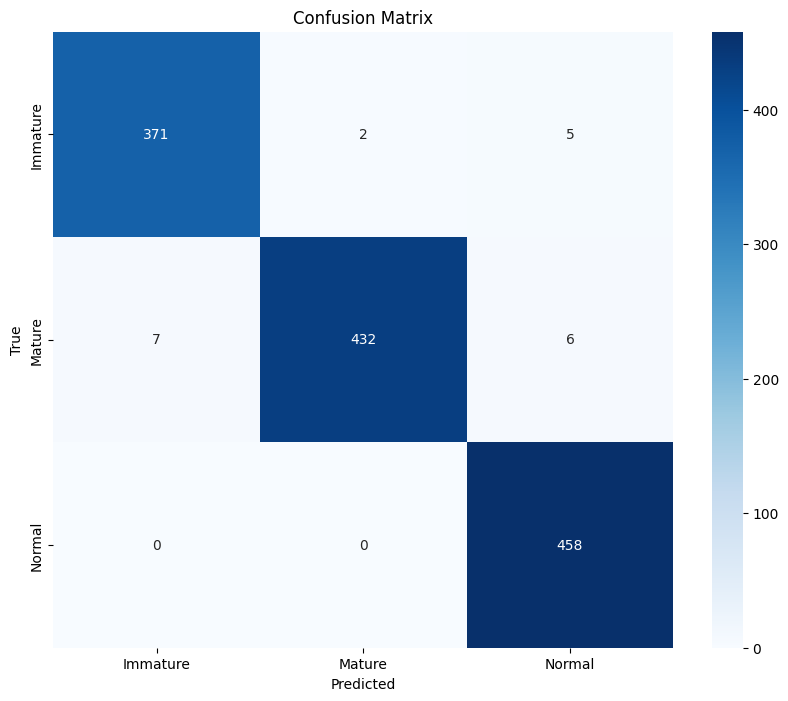

In [ ]:
# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Save the Model

In [ ]:
# Save the model
MODEL_BASE_PATH = "/content/drive/MyDrive/Bangkit 2024"
PROJECT_NAME = "H5"
SAVE_MODEL_NAME = "DenseNet.h5"
save_model_path = os.path.join(MODEL_BASE_PATH, PROJECT_NAME, SAVE_MODEL_NAME)
if not os.path.exists(os.path.join(MODEL_BASE_PATH, PROJECT_NAME)):
    os.makedirs(os.path.join(MODEL_BASE_PATH, PROJECT_NAME))

print(f'Saving Model At {save_model_path}...')
model.save(save_model_path, include_optimizer=False)

Saving Model At /content/drive/MyDrive/Bangkit 2024/H5/DenseNet.h5...


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# convert model to tflite

In [ ]:
import tensorflow as tf
import os

# Load the saved Keras model
print('Loading the saved Keras model...')
model = tf.keras.models.load_model(save_model_path)

# Convert the model to TFLite format
print('Converting to TFLite format...')
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]  # Optional: Set optimization strategy
converter.target_spec.supported_types = [tf.uint8]  # Ensure the model is saved with UINT8 data type

# Generate the TFLite model
tflite_model = converter.convert()

# Define the TFLite model path
tflite_model_path = os.path.join(MODEL_BASE_PATH, PROJECT_NAME, "DenseNet.tflite")

# Save the TFLite model
with open(tflite_model_path, 'wb') as f:
    f.write(tflite_model)

print("The model was successfully converted to TFLite and saved as {}".format(tflite_model_path))

Loading the saved Keras model...


Converting to TFLite format...
The model was successfully converted to TFLite and saved as /content/drive/MyDrive/Bangkit 2024/H5/DenseNet.tflite


In [ ]:
from tflite_support.metadata_writers import image_classifier
from tflite_support.metadata_writers import writer_utils

# Add metadata to the TensorFlow Lite model
print('Adding metadata to the TFLite model...')
ImageClassifierWriter = image_classifier.MetadataWriter
_MODEL_PATH = tflite_model_path
_SAVE_TO_PATH = os.path.join(MODEL_BASE_PATH, PROJECT_NAME, "DenseNetmetadata.tflite")
_LABEL_FILE = os.path.join(MODEL_BASE_PATH, PROJECT_NAME, "labels.txt")

# Create the labels.txt file with the desired labels
with open(_LABEL_FILE, 'w') as f:
    f.write("Normal\nImmature\nMature\n")

# Load the TFLite model
with open(tflite_model_path, 'rb') as f:
    tflite_model = f.read()

# Create metadata writer and populate metadata
populator = image_classifier.MetadataWriter.create_for_inference(
    model_buffer=tflite_model,
    input_norm_mean=[127.5],  # Normalization mean
    input_norm_std=[127.5],   # Normalization standard deviation
    label_file_paths=[_LABEL_FILE]
)

# Populate metadata
tflite_model_with_metadata = populator.populate()

# Save the TFLite model with metadata
with open(_SAVE_TO_PATH, 'wb') as f:
    f.write(tflite_model_with_metadata)

print("The TFLite model with metadata was successfully saved as {}".format(_SAVE_TO_PATH))

Adding metadata to the TFLite model...
The TFLite model with metadata was successfully saved as /content/drive/MyDrive/Bangkit 2024/H5/DenseNetmetadata.tflite


# Prediction and model test

In [ ]:
import tensorflow as tf
import numpy as np
import cv2

# Load the TFLite model with metadata and allocate tensors
interpreter = tf.lite.Interpreter(model_path='/content/drive/MyDrive/Bangkit 2024/H5/DenseNetmetadata.tflite')
interpreter.allocate_tensors()

# Get input and output tensors
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Load labels from metadata
with open('/content/drive/MyDrive/Bangkit 2024/H5/labels.txt', 'r') as f:
    labels = f.read().splitlines()

# Prepare the input image
image = cv2.imread('/content/katarak.jpg')
input_image = cv2.resize(image, (416, 416))
input_image = np.expand_dims(input_image, axis=0).astype(np.float32)

# Normalize input image
input_image = (input_image / 127.5) - 1.0

# Set the tensor to the first input of the interpreter
interpreter.set_tensor(input_details[0]['index'], input_image)

# Run inference
interpreter.invoke()

# Get the output tensor
output_data = interpreter.get_tensor(output_details[0]['index'])

# Find the label with the highest probability
predicted_label_index = np.argmax(output_data)
predicted_label = labels[predicted_label_index]
predicted_confidence = output_data[0][predicted_label_index]

print(f"Predicted Label: {predicted_label}, Confidence: {predicted_confidence:.2f}")

Predicted Label: Mature, Confidence: 1.00


FileUpload(value={}, accept='image/*', description='Upload')

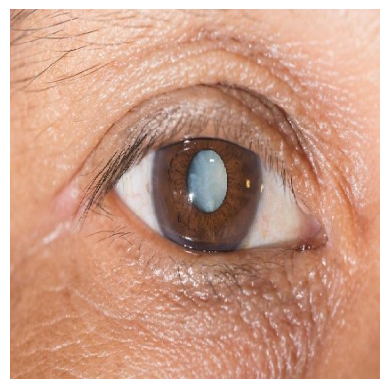

1/1 [==============================] - 3s 3s/step
Predicted Label for katarak.jpg: Mature


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
from ipywidgets import widgets
from IPython.display import display
from tensorflow.keras.applications.densenet import preprocess_input, DenseNet121

# Load DenseNet121 model with pretrained weights from ImageNet
input_shape = (416, 416, 3)  # Use 224x224 for DenseNet121 with ImageNet weights
base_model = DenseNet121(weights='imagenet', input_shape=input_shape, include_top=False)

# Add custom top layers for your specific task
x = base_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(1024, activation='relu')(x)
predictions = tf.keras.layers.Dense(3, activation='softmax')(x)  # Assuming 3 classes: normal, mature, immature

# Combine the base model with top layers
final_model = tf.keras.Model(inputs=base_model.input, outputs=predictions)

# Function to load and preprocess the image for DenseNet
def load_and_preprocess_image(image_path):
    # Load the image with the target size of 416x416 for DenseNet121 with ImageNet weights
    img = image.load_img(image_path, target_size=(416, 416))
    # Convert the image to an array
    img_array = image.img_to_array(img)
    # Expand dimensions to match the input shape of DenseNet121
    img_array = np.expand_dims(img_array, axis=0)
    # Preprocess the image using DenseNet121 preprocess function
    img_array = preprocess_input(img_array)
    return img_array

# Define your class labels
class_labels = ['Normal', 'Mature', 'Immature']

# Function to predict using the pretrained DenseNet121 model
def predict_image(image_path):
    # Load and preprocess the image
    img_array = load_and_preprocess_image(image_path)
    # Make a prediction using the pretrained DenseNet121 model
    predictions = final_model.predict(img_array)
    # Get the predicted class index
    predicted_class_idx = np.argmax(predictions, axis=1)[0]
    # Get the predicted label from class labels
    predicted_label = class_labels[predicted_class_idx]
    return predicted_label

# File upload widget to upload images
upload_widget = widgets.FileUpload(accept='image/*', multiple=False)

# Callback function when a file is uploaded
def on_file_upload_change(change):
    for filename, file_info in upload_widget.value.items():
        # Save the uploaded file
        with open(filename, 'wb') as f:
            f.write(file_info['content'])
        # Display the uploaded image
        img = image.load_img(filename, target_size=(416, 416))
        plt.imshow(img)
        plt.axis('off')
        plt.show()
        # Make a prediction
        predicted_label = predict_image(filename)
        print(f"Predicted Label for {filename}: {predicted_label}")

# Observe changes in the file upload widget
upload_widget.observe(on_file_upload_change, names='value')

# Display the file upload widget
display(upload_widget)
